In [ ]:
!nvidia-smi

Sat Jul 23 11:21:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://data.vision.ee.ethz.ch/timofter/MAI21Depth/MAI2021_depth_train.zip -O train.zip
!unzip -qq train.zip -d train
!rm train.zip

--2022-07-06 09:45:18--  https://data.vision.ee.ethz.ch/timofter/MAI21Depth/MAI2021_depth_train.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5533664070 (5.2G) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]   5.15G  20.1MB/s    in 5m 18s  

2022-07-06 09:50:37 (16.6 MB/s) - ‘train.zip’ saved [5533664070/5533664070]



In [ ]:
!wget http://data.vision.ee.ethz.ch/ihnatova/depth_validation_rgb_data.zip -O test.zip
!unzip -qq test.zip -d test
!rm test.zip

--2022-07-06 09:51:46--  http://data.vision.ee.ethz.ch/ihnatova/depth_validation_rgb_data.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/ihnatova/depth_validation_rgb_data.zip [following]
--2022-07-06 09:51:46--  https://data.vision.ee.ethz.ch/ihnatova/depth_validation_rgb_data.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 249855375 (238M) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>] 238.28M  19.7MB/s    in 14s     

2022-07-06 09:52:01 (16.7 MB/s) - ‘test.zip’ saved [249855375/249855375]



In [ ]:
!pip install torchvision onnx-coreml
!pip install onnx-tf
!pip install ptflops
!pip install pytorch-msssim

In [ ]:
from typing import Optional, Union, Tuple, List

import time
import random
from pathlib import Path
from tqdm.notebook import tqdm
from IPython import display
from functools import partial
from dataclasses import dataclass, asdict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
import torchvision
from torchvision.io import read_image

from PIL import Image

import numpy as np
from matplotlib import pyplot as plt

In [ ]:
eps = 0.001

class MonoDepthRAM(Dataset):
    def __init__(self, root, val=False, test=False, transforms=None, img_resize=None):
        super(MonoDepthRAM, self).__init__()

        self.root = Path(root)
        if not test:
            self.path_to_dataset = self.root / 'train'
        else:
            self.path_to_dataset = self.root / 'test'

        self.transforms = transforms
        self.images = []
        self.depthes = []
        self.ids = []
        rgb_path = self.path_to_dataset
        if not test:
            rgb_path = rgb_path / 'rgb'
            
        id_val = 8000
        for image_path in tqdm(rgb_path.rglob('*.png')):
            img_id = int(str(image_path).split("/")[-1][:-4])
            if not test and (val and (img_id <= id_val) or not val and (img_id > id_val)):
                continue

            depth_path = image_path.as_posix().replace('rgb', 'depth')
            image_path = image_path.as_posix()

            image = read_image(image_path)
            if not test:
                depth = torchvision.transforms.functional.to_tensor(Image.open(depth_path))
                depth[depth < 1] = 1
            
            if img_resize is not None:
                image = img_resize(image)

            image = image / 255. # map to [0; 1]

            self.images.append(image)
            if not test:
                depth = depth / 1000. # map to [0; 40] meters
                self.depthes.append(depth)
            self.ids.append(img_id)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        if self.depthes:
            depth = self.depthes[index]
        else:
            depth = None

        if self.transforms is not None:
            image, depth = self.transforms(image, depth)

        if self.depthes:
            return image, depth
        else:
            return image

In [ ]:
normalize_rgb = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])

color_jitter = torchvision.transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)

def transforms_train(image, depth):
    image = color_jitter(image)

    if random.random() < 0.5:
        image = torchvision.transforms.functional.hflip(image)
        depth = torchvision.transforms.functional.hflip(depth)

    angle = random.random() * 10 - 5
    image = torchvision.transforms.functional.rotate(image, angle)
    depth = torchvision.transforms.functional.rotate(depth, angle)
    depth[depth < eps] = eps

    # TODO: add random crop
    sigma = random.choice([0.01, 0.015, 0.02])
    mean  = 0
    noise = torch.randn(image.size()) * sigma + mean
    image = image + noise

    return normalize_rgb(image), depth

RESIZES_HEIGHT = 160 # 320
RESIZES_WIDTH = 128 # 256

def resize(image):
    return torchvision.transforms.functional.resize(image, [RESIZES_WIDTH, RESIZES_HEIGHT])

def trainsforms_test(image, depth):
    return normalize_rgb(image), depth

In [ ]:
train_dataset = MonoDepthRAM(
    root="./train",
    val=False, 
    test=False,
    transforms=transforms_train,
    img_resize=resize
)

0it [00:00, ?it/s]

In [ ]:
val_dataset = MonoDepthRAM(
    root="./train",
    val=True, 
    test=False,
    transforms=trainsforms_test,
    img_resize=resize
)

0it [00:00, ?it/s]

In [ ]:
test_dataset = MonoDepthRAM(
    root="./",
    val=False, 
    test=True,
    transforms=trainsforms_test,
    img_resize=resize
)

0it [00:00, ?it/s]

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(7050, 335, 500)

In [ ]:
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, drop_last=False
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=1
)

In [ ]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

def rmse(target, img):
    #img[img < eps] = eps
    #target[target < eps] = eps
    mask = torch.asarray(target > eps, dtype=int)

    diff = (target - img) * mask #/ 1000.0   # mapping the distance from millimeters to meters
    num_pixels = float(torch.sum(mask > 0))
    return torch.sqrt(torch.sum(torch.square(diff)) / num_pixels)

def si_rmse(target, img):
    mask = torch.asarray(target > eps, dtype=int)
    log_diff = (torch.log(img) - torch.log(target)) * mask
    num_pixels = torch.sum(mask > 0)
    return torch.sqrt(torch.sum(torch.square(log_diff)) / num_pixels - torch.square(torch.sum(log_diff)) / torch.square(num_pixels))

class SiLogLoss(nn.Module):
    def __init__(self, lambd=0.5):
        super().__init__()
        self.lambd = lambd

    def forward(self, pred, target):
        valid_mask = (target > eps).detach()
        diff_log = torch.log(target[valid_mask]) - torch.log(pred[valid_mask])
        loss = torch.sqrt(torch.square(diff_log).mean() - self.lambd * torch.square(diff_log.mean()))

        return loss

def criterions(target, output):
    '''
    https://github.com/VainF/pytorch-msssim
    https://github.com/ialhashim/DenseDepth/blob/master/loss.py
    https://github.com/vinvino02/GLPDepth/blob/7fd76faa696198f2e965970cbfbffe74dd5900b4/code/utils/criterion.py
    '''
    
    dist  = torch.mean((target - output)**2)
    
    ssim_loss= SSIM(data_range=40, size_average=True, channel=1)
    ssim = ssim_loss(target,output)
    
    wsilogloss= SiLogLoss()
    wsiloss = wsilogloss(target,output)

    siloss = si_rmse(target,output)
    
    #loss = dist + (10*(1-ssim)) + (10*siloss)
    return dist, ssim, siloss, wsiloss

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [ ]:
from collections import OrderedDict

class DConv2d(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class FFM(nn.Module):
    def __init__(self, nin, nhid, nout):
        super().__init__()
        self.decoder1 = nn.Sequential(
            nn.Conv2d(nin, nin, 1),
            nn.UpsamplingBilinear2d(scale_factor=2),
            DConv2d(nin, nhid)
        )
        self.decoder2 = DConv2d(2 * nhid, nout)

    def forward(self, x, y):
        return self.decoder2(torch.cat((self.decoder1(x), y), dim=1))

class MobileNetDepthEstimation(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        feature_extractor = torchvision.models.mobilenet_v3_small(pretrained=pretrained).features
        self.encoder = nn.ModuleList([
            nn.Sequential(feature_extractor[0]), # 1/2 resolution
            nn.Sequential(feature_extractor[1]), # 1/4 resolution
            nn.Sequential(feature_extractor[2], feature_extractor[3]), # 1/8 resolution
            nn.Sequential(feature_extractor[4], feature_extractor[5], feature_extractor[6], feature_extractor[7], feature_extractor[8]), # 1/16 resolution
            nn.Sequential(feature_extractor[9], feature_extractor[10], feature_extractor[11]), # 1/32
        ])
        self.decoder = nn.ModuleList([
            FFM(96, 48, 48),
            FFM(48, 24, 24),
            FFM(24, 16, 16),
            FFM(16, 16, 16),
            FFM(16, 3, 1)
        ])
    
    def forward(self, x):
        xs = [x.clone()]
        for backbone in self.encoder:
            x = backbone(x)
            xs.append(x.clone())

        for i, ffm in enumerate(self.decoder):
            x = ffm(x, xs[len(self.encoder) - 1 - i])
        
        x = (torch.tanh(x) + 1) / 2 * 40 # map y to [0;40] meters
        x = torch.clamp(x, min=eps, max=40.)
        x = torch.nn.functional.interpolate(x, (480, 640), mode="nearest") # upscale to basic resolution
    
        return x

In [ ]:
model = MobileNetDepthEstimation()
img = torch.rand(1, 3, 224, 224)
print(model(img).shape)
img = torch.rand(1, 3, RESIZES_HEIGHT, RESIZES_WIDTH)
print(model(img).shape)

torch.Size([1, 1, 480, 640])
torch.Size([1, 1, 480, 640])


In [ ]:
X_batch, Y_batch = next(iter(train_dataloader))
Y_batch.min(), Y_batch.max()

(tensor(0.0010), tensor(39.9970))

In [ ]:
with torch.no_grad():
    depth = model(X_batch)

In [ ]:
depth.min(), depth.max()

(tensor(8.0944), tensor(38.1488))

In [ ]:
dist, ssim, siloss, wsiloss = criterions(
    Y_batch, depth
)

In [ ]:
ssim

tensor(0.3201)

In [ ]:
idx = np.random.randint(0, BATCH_SIZE - 1)

In [ ]:
depth[idx][0].shape

torch.Size([480, 640])

In [ ]:
from collections import defaultdict
from itertools import islice

def train_network(network, opt, criterion, lambda_ssim=10, lambda_sirmse=10, sheduler=None, num_epochs=200, checkpoint_every=None, dir_checkpoint=None):
    metrics = defaultdict(list)

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = []
        val_loss = []
        train_scale_losses = []
        val_scale_losses = []
        val_rmse = []
        val_si_rmse = []
        val_wsi_rmse = []
        val_ssim = []
        val_dist = []

        network.train()
        for X_batch, Y_batch in tqdm(train_dataloader):
            opt.zero_grad()

            X_batch = X_batch.to(device)
            Y_batch = Y_batch.float().to(device)

            depth = network(X_batch)

            dist, ssim, siloss, wsiloss = criterion(
                Y_batch, depth
            )
            
            loss = dist + lambda_ssim * (1 - ssim) + lambda_sirmse * siloss

            loss.backward()
            opt.step()
            if sheduler is not None:
                sheduler.step()

            train_loss.append(loss.item())

        network.eval()
        with torch.no_grad():
            for X_batch, Y_batch in tqdm(val_dataloader):
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.float().to(device)

                depth = network(X_batch)

                dist, ssim, siloss, wsiloss = criterion(
                    Y_batch, depth
                )

                loss = dist + lambda_ssim * (1 - ssim) + lambda_sirmse * siloss

                val_dist.append(dist.item())
                val_loss.append(loss.item())
                val_rmse.append(rmse(Y_batch, depth).item())
                val_si_rmse.append(siloss.item())
                val_wsi_rmse.append(wsiloss.item())
                val_ssim.append(ssim.item())

        metrics['train_loss'].append(np.mean(train_loss))
        metrics['val_loss'].append(np.mean(val_loss))
        metrics['val_rmse'].append(np.mean(val_rmse))
        metrics['val_si_rmse'].append(np.mean(val_si_rmse))
        metrics['val_wsi_rmse'].append(np.mean(val_wsi_rmse))
        metrics['val_ssim'].append(1 - np.mean(val_ssim))
        metrics['val_dist'].append(np.mean(val_dist))

        display.clear_output(True)
        fig = plt.figure(figsize=(20, 7))
        ax1 = plt.subplot(3, 3, 1)

        idx = np.random.randint(0, depth.shape[0] - 1)
        ax1.imshow(depth[idx][0].detach().cpu().numpy(), "plasma", vmin=0, vmax=40)

        ax2 = plt.subplot(3, 3, 4)
        ax2.imshow(Y_batch[idx].detach().cpu().squeeze().numpy(), "plasma", vmin=0, vmax=40)
        
        ax3 = plt.subplot(3, 3, 7)
        ax3.imshow(X_batch[idx].detach().cpu().permute(1, 2, 0).numpy())
        
        ax4 = plt.subplot(3, 3, 2)
        ax4.plot(metrics['train_loss'], label='train')
        ax4.plot(metrics['val_loss'], label='val')
        ax4.set_xlabel('Epochs', fontsize=20)
        ax4.set_ylabel('LOSS', fontsize=20)
        ax4.grid()
        ax4.legend()

        ax5 = plt.subplot(3, 3, 8)
        ax5.plot(metrics['val_rmse'])
        ax5.set_title('rmse')
        ax5.grid()

        ax6 = plt.subplot(3, 3, 9)
        ax6.plot(metrics['val_si_rmse'])
        ax6.set_title('val si-rmse')
        ax6.grid()

        ax7 = plt.subplot(3, 3, 5)
        ax7.plot(metrics['val_wsi_rmse'])
        ax7.set_title('val wsi-rmse')
        ax7.grid()

        ax8 = plt.subplot(3, 3, 6)
        ax8.plot(metrics['val_ssim'])
        ax8.set_title('val ssim')
        ax8.grid()

        ax9 = plt.subplot(3, 3, 3)
        ax9.plot(np.array(metrics['val_dist']), label="dist")
        ax9.plot(np.array(metrics['val_ssim']) * lambda_ssim, label="ssim")
        ax9.plot(np.array(metrics['val_wsi_rmse']) * lambda_sirmse, label="wsi-rmse")
        ax9.legend()
        ax9.set_title('val loss scaled')
        ax9.grid()

        fig.tight_layout()
        
        plt.show()
        print(
            f"Epoch {epoch + 1} of {num_epochs} "
            f"took {time.time() - start_time:.3f}s\n"
        )

        if (checkpoint_every is not None) and ((epoch + 1) % checkpoint_every == 0):
            torch.save(network, dir_checkpoint + "_" + epoch)

In [ ]:
epochs = 100

model = MobileNetDepthEstimation(pretrained=True)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# WarmUp
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=1e-3,
                                                steps_per_epoch=len(train_dataloader), 
                                                epochs=epochs)

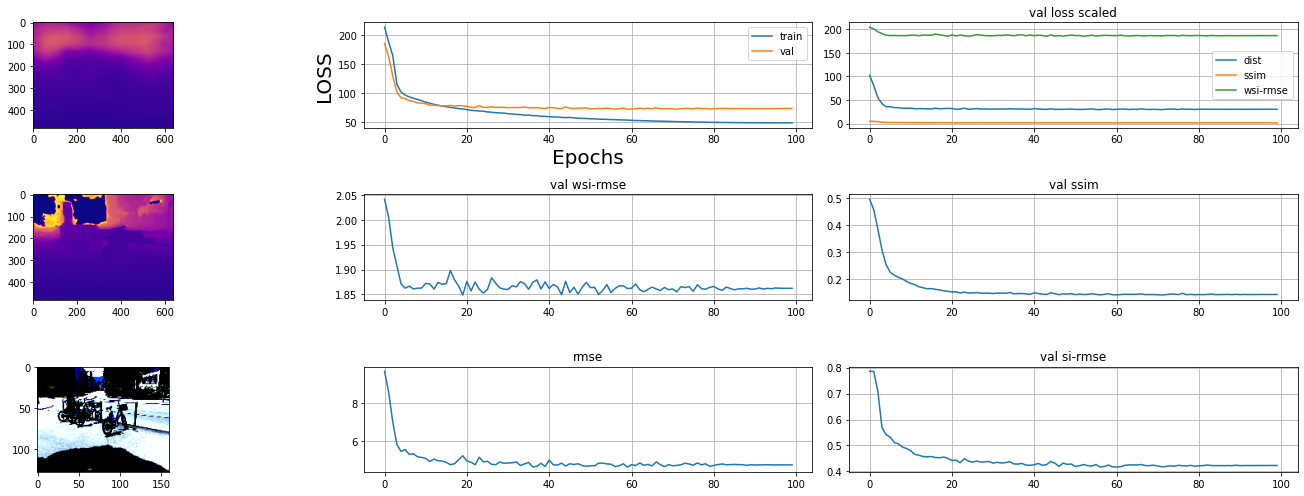

Epoch 100 of 100 took 61.293s



In [ ]:
train_network(
    network=model, 
    opt=optimizer,
    criterion=criterions,
    lambda_ssim=10,
    lambda_sirmse=100,
    sheduler=scheduler,
    num_epochs=epochs
)

# End-to-end

In [ ]:
from copy import deepcopy
import onnx
from onnx_tf.backend import prepare

import tensorflow as tf

def save_tf_lite_model(model, name_model):
    model = deepcopy(model)

    # Creating / loading pre-trained PyNET model
    model.eval()
    model = model.cpu()

    # Converting model to ONNX

    for _ in model.modules():
        _.training = False

    sample_input = torch.randn(1, 480, 640, 3)
    input_nodes = ['input']
    output_nodes = ['output']

    torch.onnx.export(model, sample_input, f"{name_model}.onnx", export_params=True, input_names=input_nodes, output_names=output_nodes, opset_version=11)

    # Converting model to Tensorflow

    onnx_model = onnx.load(f"{name_model}.onnx")
    output = prepare(onnx_model)
    output.export_graph("tf_model/")

    # Exporting the resulting model to TFLite

    converter = tf.lite.TFLiteConverter.from_saved_model("tf_model")
    tflite_model = converter.convert()
    open(f"{name_model}.tflite", "wb").write(tflite_model)

In [ ]:
from ptflops import get_model_complexity_info

def show_model_statistics(model):
    with torch.cuda.device(0):
        macs, params = get_model_complexity_info(model, (480, 640, 3), as_strings=True,
                                                print_per_layer_stat=True, verbose=False)
        print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
        print('{:<30}  {:<8}'.format('Number of parameters: ', params))

In [ ]:
class EndToEnd(nn.Module):
    def __init__(self, model, augmentations):
        super().__init__()
        self.model = model
        self.augmentations = augmentations
    def forward(self, input):
        return self.model(self.augmentations(input)).permute(0, 2, 3, 1) * 1000

end_to_end_augmentations = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x.permute(0, 3, 1, 2)),
    torchvision.transforms.Lambda(lambda x: x / 255.),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    torchvision.transforms.Resize([RESIZES_WIDTH, RESIZES_HEIGHT], interpolation=torchvision.transforms.InterpolationMode.NEAREST)
])

In [ ]:
import os

def save_predictions(name):
    fig, _ = plt.subplots(3, 3, figsize=(20, 20))

    interpreter = tf.lite.Interpreter(model_path=f"{name}.tflite")
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_shape = input_details[0]['shape']
    for i, image_path in tqdm(enumerate(os.listdir("test"))):
        input_data = read_image("test/" + image_path).permute(1, 2, 0).reshape(1, 480, 640, 3).float()
        interpreter.set_tensor(input_details[0]['index'], input_data)

        interpreter.invoke()

        output_data = interpreter.get_tensor(output_details[0]['index'])
        output_data = output_data[0,:,:,0].astype(np.int32)
        plt.imshow(output_data, "plasma", vmin=0, vmax=40_000)
        img = Image.fromarray(output_data)
        img.save(os.path.join(name, image_path))

        if i < 9:
            plt.subplot(3, 3, i+1)
            plt.imshow(output_data, "plasma", vmin=0, vmax=40_000)

In [ ]:
def full_test_model(train_model, name):
    end_to_end_model = EndToEnd(train_model, end_to_end_augmentations)
    show_model_statistics(end_to_end_model)
    save_tf_lite_model(end_to_end_model, name)
    save_predictions(name)

mkdir: cannot create directory ‘mobile_net_small_ffm_metrics’: File exists
EndToEnd(
  900.96 k, 100.000% Params, 41.43 MMac, 100.000% MACs, 
  (model): MobileNetDepthEstimation(
    900.96 k, 100.000% Params, 41.43 MMac, 100.000% MACs, 
    (encoder): ModuleList(
      870.56 k, 96.626% Params, 23.01 MMac, 55.548% MACs, 
      (0): Sequential(
        464, 0.052% Params, 2.38 MMac, 5.734% MACs, 
        (0): ConvNormActivation(
          464, 0.052% Params, 2.38 MMac, 5.734% MACs, 
          (0): Conv2d(432, 0.048% Params, 2.21 MMac, 5.339% MACs, 3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, 0.004% Params, 163.84 KMac, 0.395% MACs, 16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Hardswish(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
        )
      )
      (1): Sequential(
        744, 0.083% Params, 635.17 KMac, 1.533% MACs, 
        (0): InvertedResidual(
          744, 0.083% Params, 635.17 KMac

INFO:tensorflow:Assets written to: tf_model/assets


INFO:tensorflow:Assets written to: tf_model/assets


0it [00:00, ?it/s]

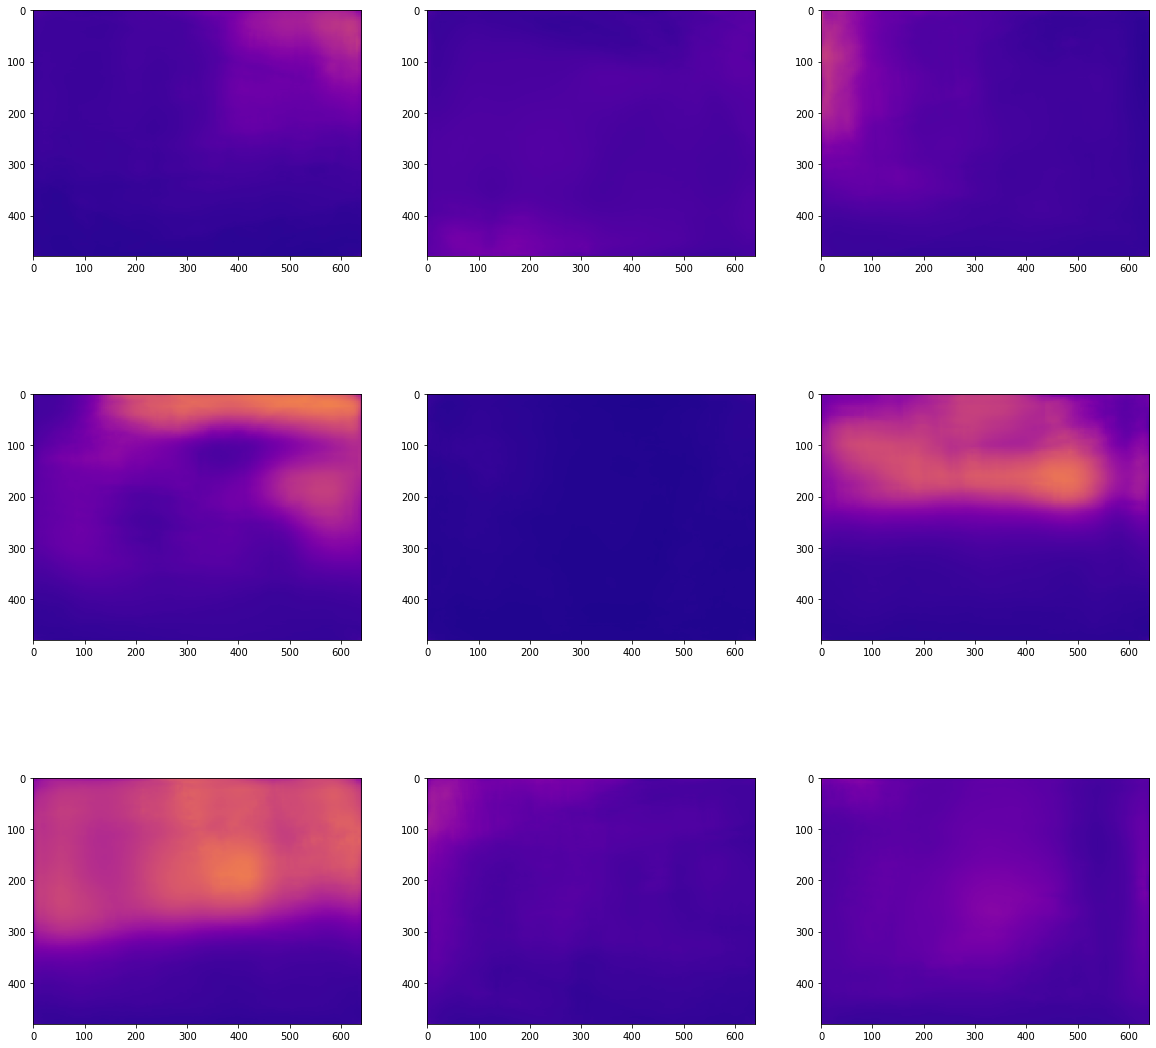

In [ ]:
!mkdir mobile_net_small_ffm_metrics
full_test_model(model, "mobile_net_small_ffm_metrics")

In [ ]:
!cp mobile_net_small_ffm_metrics.tflite mobile_net_small_ffm_metrics/model.tflite

!echo runtime per image [s] : 0.004 > mobile_net_small_ffm_metrics/readme.txt
!echo CPU[1] / GPU[0] : 0 >> mobile_net_small_ffm_metrics/readme.txt
!echo Extra Data [1] / No Extra Data [0] : 0 >> mobile_net_small_ffm_metrics/readme.txt
!echo Other description : Mobile Net architecture mse error >> mobile_net_small_ffm_metrics/readme.txt

In [ ]:
!rm mobile_net_small_ffm_metrics.zip
!zip -r -j -q mobile_net_small_ffm_metrics.zip mobile_net_small_ffm_metrics

In [ ]:
from google.colab import files
files.download('mobile_net_small_ffm_metrics.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>